# Implementation of simple contact network

In [1]:
import numpy as np
from tqdm import tqdm
import sys
import copy
from numba import jit, njit

# network stuff
import networkx as nx
from networkx.utils.random_sequence import (powerlaw_sequence)

# plotting
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml') # use either html5 or jshtml
%matplotlib notebook

# import networkx.utils.create_degree_sequence as create_degree_sequence
# from multiprocessing import Pool

## Build a network

In [2]:
def create_degree_sequence(n, sfunction=None, max_tries=50, **kwds):
    """ Attempt to create a valid degree sequence of length n using
    specified function sfunction(n,**kwds).

    Parameters
    ----------
    n : int
        Length of degree sequence = number of nodes
    sfunction: function
        Function which returns a list of n real or integer values.
        Called as "sfunction(n,**kwds)".
    max_tries: int
        Max number of attempts at creating valid degree sequence.
        
    source: https://networkx.github.io/documentation/networkx-1.10
    """
    tries=0
    max_deg=n
    while tries < max_tries:
        trialseq=sfunction(n,**kwds)
        # round to integer values in the range [0,max_deg]
        seq=[min(max_deg, max( int(round(s)),0 )) for s in trialseq]
        # if graphical return, else throw away and try again
        if nx.is_graphical(seq):
            return seq
        tries+=1
    raise nx.NetworkXError("Exceeded max (%d) attempts at a valid sequence."%max_tries)

In [3]:
def power_law_graph(exp, num, seed=1234, plot=False):
    """
    Function which creates power law graph based on a number of nodes (num),
    an exponent (exp) and a seed. 
    
    source: http://nbviewer.jupyter.org/gist/Midnighter/248f1a5d8c21b39525ae
    """
    
    print("Power law exponent = -{0:.2f}".format(exp))
    
    # create graph
    sequence = create_degree_sequence(num, powerlaw_sequence, exponent=exp)
    graph = nx.configuration_model(sequence, seed=seed)

    # count parallel edges and avoid counting A-B as well as B-A
    num_par = sum(
        len(graph[node][neigh]) for node in graph
        for neigh in graph.neighbors(node)) // 2
    print("Power law graph has {0:d} parallel edges".format(num_par))
    loops = graph.selfloop_edges()

    # remove them
    graph = nx.Graph(graph)
    graph.remove_edges_from(loops)
    
    # get largest connected component
    # unfortunately, the iterator over the components is not guaranteed to be sorted by size
    components = sorted(nx.connected_components(graph), key=len, reverse=True)
    lcc = graph.subgraph(components[0])
    print("Size of largest connected component = {0:d}".format(len(lcc)))
    
    if plot == True:

        # new degree sequence
        simple_seq = [deg for (node, deg) in lcc.degree()]

        # create histograms
        counts = np.bincount(sequence)
        mask = (counts > 0)
        plt.figure()
        plt.plot(
            np.arange(len(counts))[mask],
            counts[mask] / counts.sum(),
            "o",
            label="MultiGraph")
        simple_counts = np.bincount(simple_seq)
        mask = (simple_counts > 0)

        # distribution is shifted for visibility
        plt.plot(
            np.arange(len(simple_counts))[mask],
            simple_counts[mask] / simple_counts.sum() / 10.0,
            "o",
            label="Simple LCC")

        # plot distribution
        x = np.arange(1, len(counts))
        plt.plot(x, np.power(x, -exp))
        plt.xlabel(r"Degree $k$")
        plt.xscale("log")
        plt.ylabel(r"Probability $P(k)$")
        plt.yscale("log")
        plt.title(r"$N = {0:d}, \\quad \\lambda = {1:.2f}$".format(num, exp))
        plt.legend(loc="best")
        plt.show()
        nx.powerlaw_cluster_graph

        # visualize network
        plt.figure()
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos, node_color='b', node_size=10, with_labels=False)
        plt.show()
    return graph

In [4]:
def random_network(p, num, seed=1234, plot=False):
    """
    Function which creates random network based on edge probability (p),
    a given number of nodes (num) and a seed. 
    """
    
    # create graph
    graph = nx.fast_gnp_random_graph(num, p, seed=seed, directed=False)

    # plot
    if plot == True:
        plt.figure()
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos, node_color='b', node_size=5, with_labels=False)
        plt.show()

        plt.figure()
        degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
        # print "Degree sequence", degree_sequence
        dmax = max(degree_sequence)

        plt.semilogy(degree_sequence, 'b-', marker='o')
        plt.title("Degree rank plot")
        plt.ylabel("degree")
        plt.xlabel("rank")
        plt.show()
    return graph

## Implementation of disease spreading

In [5]:
class Person():
    """ 
    Contains data about status of infection for each person.
    
    time_since_infection equals -1 if person is not infected.
    
    The disease status is 0 for no disease, 1 for the sensitive
    strain and 2 for the resistant strain.
    """
    
    def __init__(self,i):
        self.identifier = i
        self.disease_status = 0
        self.time_since_infection = -1

In [31]:
def model(beta, tau, nu, init, num_steps, graph, doInit = False, disable_progress=False):
    """
    Function which runs disease spreading model on specified network.
    
    beta = transmission probability
    tau = probability of treatment
    nu = probability of recovering spontaneously
    init = initial number of infecteds (with sensitive strain)
    num_steps = number of iterations to run model
    graph = an initialized graph, e.g. random or scale-free
    doInit = boolean specifying to initialize or not
    """
    
    # arrays/set containing number of diseased
    num_infected  = np.zeros(num_steps)
    num_res = np.zeros(num_steps)
    infected = set()
    
    # initialization of infected individuals
    if doInit:
        for i in range(len(graph)):
            graph.node[i]["Data"].disease_status = 0
        for i in init[:]:
            graph.node[i]["Data"].disease_status = 1
            infected.add(i)
#         for i in init[-10:]:
#             graph.node[i]["Data"].disease_status = 2
#             infected.add(i)
    else:
        for i in range(len(graph)):
            if graph.node[i]["Data"].disease_status:
                infected.add(i)
      
    # iterate over time
    for t in tqdm(range(num_steps), position = 0, disable=disable_progress):
        infected_copy = infected.copy()

        # iterate over infecteds 
        for i in infected_copy:

            # prob of recovering
            if np.random.rand() < nu:
                graph.node[i]["Data"].disease_status = 0
                infected.remove(i)

            # prob of treatment
            elif graph.node[i]["Data"].disease_status == 1 and np.random.rand() < tau*(1-mu):
                graph.node[i]["Data"].disease_status = 0
                infected.remove(i)

            # prob of getting the resistant strain
            elif graph.node[i]["Data"].disease_status == 1 and np.random.rand() < tau*mu:
                graph.node[i]["Data"].disease_status = 2

            # spreading of disease to neigbours
            if graph.node[i]["Data"].disease_status:
                for neighbor in graph.neighbors(i):
                    if graph.node[neighbor]["Data"].disease_status == 0 and np.random.rand() < beta:
                        graph.node[neighbor]["Data"].disease_status = graph.node[i]["Data"].disease_status
                        infected.add(neighbor)

        # keep track of total number of resistant infecteds
        tot = 0
        for i in infected:
            if graph.node[i]["Data"].disease_status == 2:
                tot += 1
        num_res[t] = tot 
        num_infected[t] = len(infected)
    return (num_res, num_infected, graph)

## Running the model

In [70]:
# create power law graph
# exp = 2.4
# seed = 123456789
# num = 1000
# graph = power_law_graph(exp, num, seed, plot= True)

# # or, create random network
degree = 10
num = 500
p = degree/num
seed = 1234
graph = random_network(p, num, seed)

In [78]:
# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Person(i)

# create set of infecteds, initialize with 10 infecteds
init = np.random.choice(len(graph), 10, replace=False)

# time steps
t = 0
t_tot = 20
time_step = 365
dt = 1 / (time_step)

# constants of model
D = np.array([0.19,0.55]) * time_step
mu = 1e-3
PHI = [0.65, 0.50]
BETA = [0.59, 0.87]

# keep track of infecteds and steps
num_steps = int(t_tot / dt)
num_infected = np.zeros((2, num_steps))
num_res = np.zeros((2, num_steps))

# compute average degree
degrees = dict(graph.degree())
sum_of_edges = sum(degrees.values())
average_deg = sum_of_edges / len(degrees)
print(average_deg)

p_inf = 0.8
# iterate over sextypes (MSM and HMW)
for sextype in range(2):
    phi = PHI[sextype]
    beta = BETA[sextype]
    

#     print(1/(1-((1-nu)*(1-tau))))
    nu = (1 - phi)/D[sextype]
    tau = phi/D[sextype]
    beta = 1-(1-1/(average_deg*(1-p_inf)))**(nu)
    print(beta, nu, tau)
    num_res[sextype,:], num_infected[sextype,:], graph= model(beta, tau, nu, init, num_steps, \
                                                              copy.deepcopy(graph), True)

  2%|▏         | 113/7300 [00:00<00:06, 1124.51it/s]

9.752
0.00362165065445208 0.005046863734679163 0.009372746935832734


  2%|▏         | 157/7300 [00:00<00:04, 1559.12it/s]

0.0017889503708981014 0.0024906600249066 0.0024906600249066


100%|██████████| 7300/7300 [00:43<00:00, 168.66it/s]


In [9]:
p_inf = 0.20
beta = 1 - (1-1/(average_deg*(1-p_inf)))**(nu)
beta2 = 1 - (1-0.59)**(1/(0.19*365))
print(beta, nu, tau)
print(beta2)

0.000671261225205666 0.005046863734679163 0.009372746935832734
0.012774206026024748


### Plotting

<IPython.core.display.Javascript object>


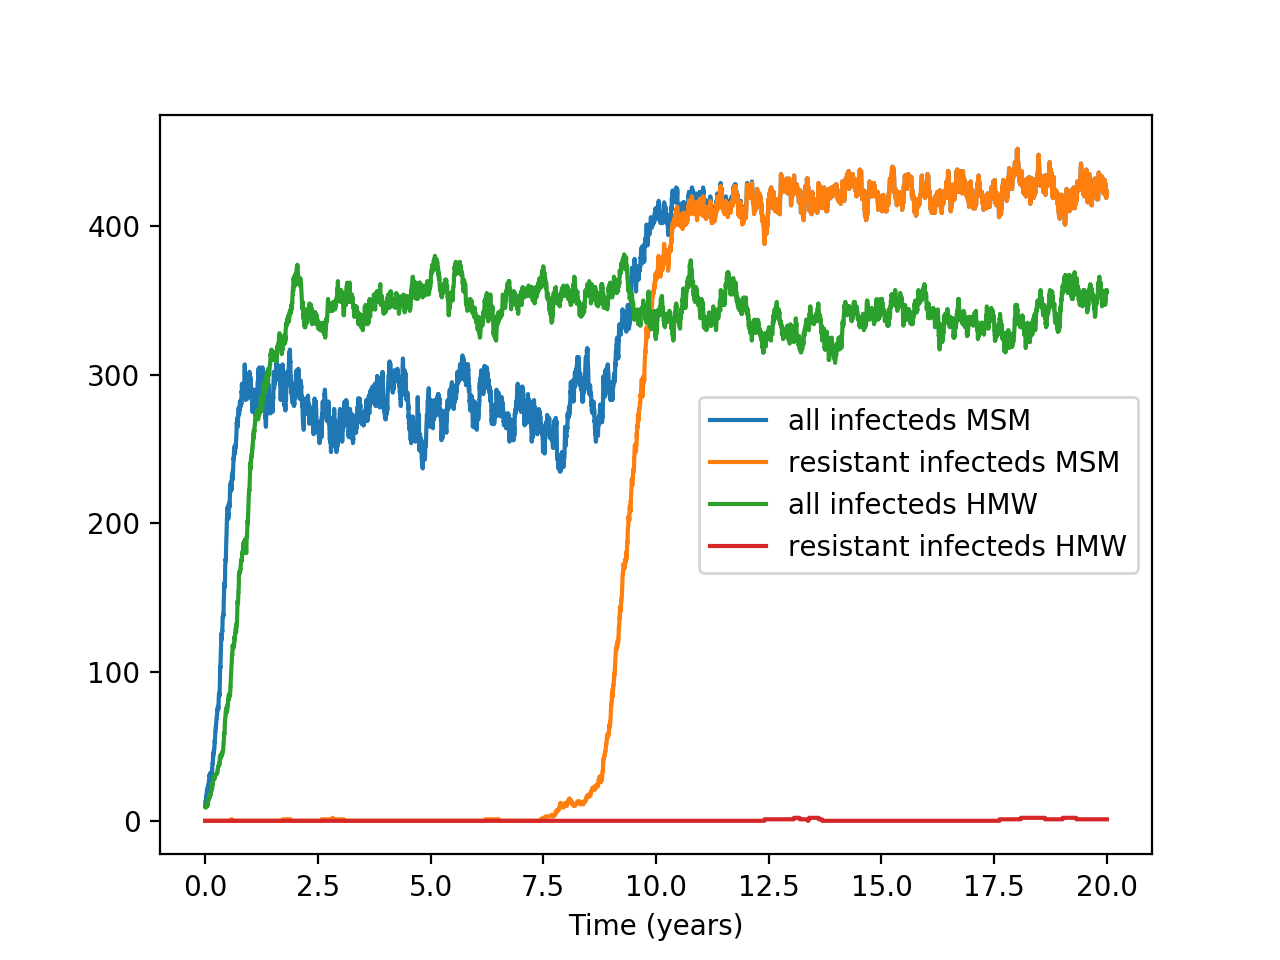

Mean number of infecteds: 348.48246575342466


<IPython.core.display.Javascript object>


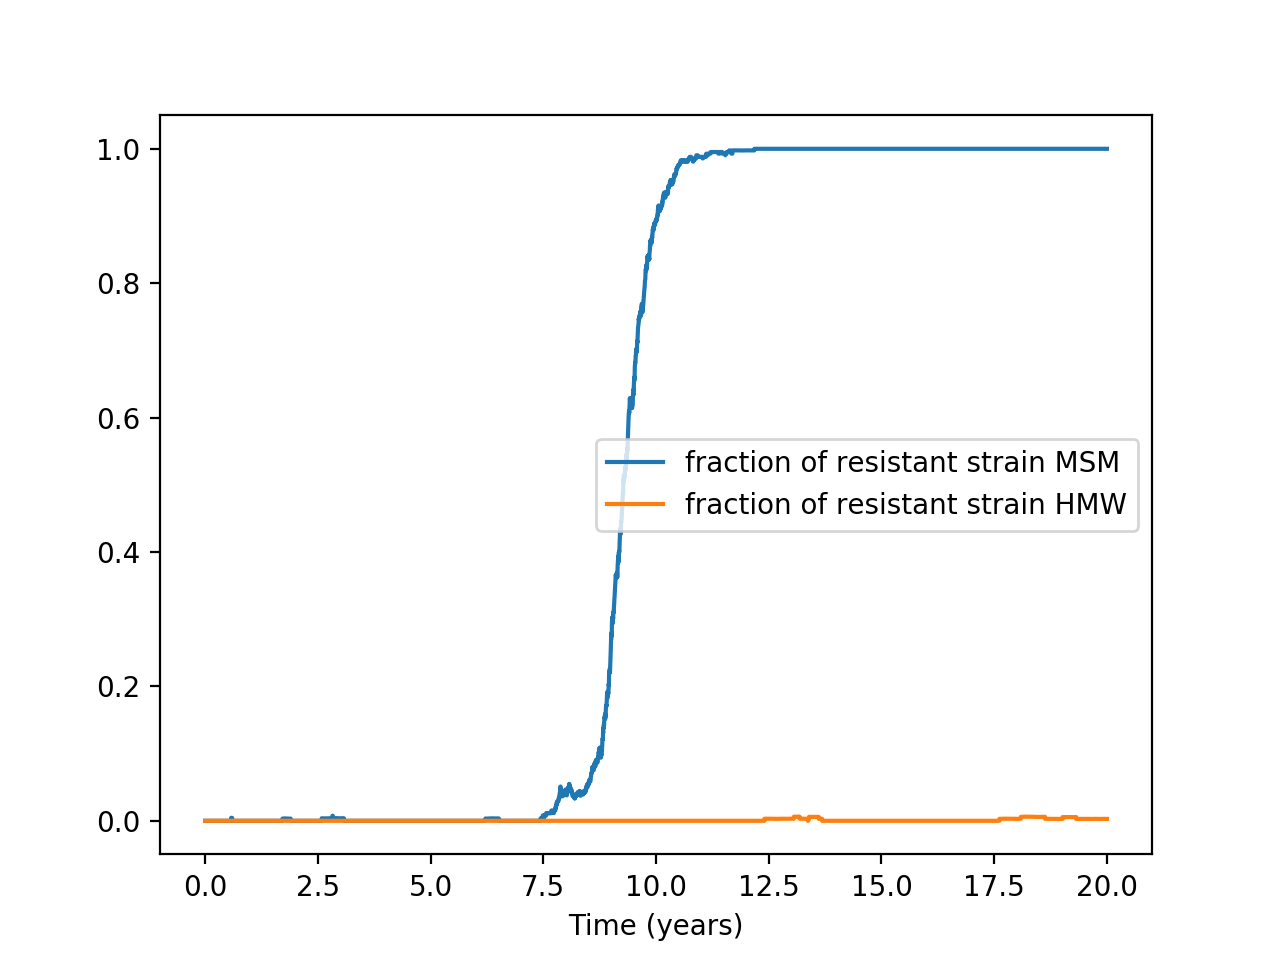

In [79]:
# plot number of infecteds
t = np.linspace(0,t_tot, num_steps)    
plt.figure()
print("Mean number of infecteds:", np.mean(num_infected[0,:]))
plt.plot(t, num_infected[0,:], label='all infecteds MSM')
plt.plot(t, num_res[0,:], label='resistant infecteds MSM')
plt.plot(t, num_infected[1,:], label='all infecteds HMW')
plt.plot(t, num_res[1,:], label='resistant infecteds HMW')
plt.xlabel("Time (years)")
plt.legend()
plt.show()

plt.figure()
plt.plot(t,num_res[0,:]/num_infected[0,:], label='fraction of resistant strain MSM')
plt.plot(t,num_res[1,:]/num_infected[1,:], label='fraction of resistant strain HMW')
plt.xlabel("Time (years)")
plt.legend()
plt.show()

### Plots for different beta (TODO)

In [ ]:
# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Person(i)

# create set of infecteds, initialize with 10 infecteds
init = np.random.choice(len(graph), 10, replace=False)

t = 0
t_tot = 10
time_step = 365
dt = 1 / (time_step)
D = 0.19 * time_step
mu = 1e-3

# constants of model
PHI = [0.65, 0.50]
BETA = np.linspace(0.15, 0.3, 10)

# keep track of infecteds and steps
num_steps = int(t_tot / dt)
num_infected = np.zeros((len(BETA), num_steps))
num_res = np.zeros((len(BETA), num_steps))

for i, beta in enumerate(BETA):
    phi = PHI[0]

    BETA = 1 - (1 - BETA)**(1 / time_step)
    nu = 2e-3 * (1 - phi)
    tau = 8e-3 * phi
    num_res[i,:], num_infected[i,:], graph = model(beta, tau, nu, init, num_steps, copy.deepcopy(graph))


# with multiprocessing.Pool(processes=3) as pool:
#     results = pool.starmap(merge_names, product(names, repeat=2))

In [ ]:
t = np.linspace(0,t_tot, num_steps)    
plt.figure()

plt.plot(BETA, num_infected[:,-1], label='all infecteds %i' % BETA[i])
plt.plot(BETA, num_res[:,-1], label='resistant infecteds %i'% BETA[i])
# plt.legend()
plt.show()

# plt.figure()
# plt.plot(t,num_res[0,:]/num_infected[0,:], label='fraction of resistant strain MSM')
# plt.plot(t,num_res[1,:]/num_infected[1,:], label='fraction of resistant strain HMW')
# # plt.plot(num_res)
# plt.legend()
# plt.show()

### Animation

In [ ]:
# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Person(i)

# create set of infecteds, initialize with 10 infecteds
init = np.random.choice(len(graph), 10, replace=False)

# time
t = 0
t_tot = 20
time_step = 365
dt = 1 / (time_step)

# constants of model
D = 0.19 * time_step
mu = 1e-3
PHI = [0.65, 0.50]
BETA = [0.59, 0.87]

# choose MSM or HMW to model
sextype = 0
phi = PHI[sextype]
beta = BETA[sextype]
beta = 1 - (1 - beta)**(1 / time_step)
nu = 2e-3 * (1 - phi)
tau = 8e-3 * phi

# initial state
_, _, graph = model(beta, tau, nu, init, 0, graph, doInit=True, disable_progress=True)

# get values of disease status
values = []
for j in range(len(graph.nodes())):
    if graph.node[j]["Data"].disease_status == 0:
        values.append("Black")
    elif graph.node[j]["Data"].disease_status == 1:
        values.append("Blue")
    elif graph.node[j]["Data"].disease_status == 2:
        values.append("Red")
        
# create figure and set axes
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1, = ax2.plot([], [], c = 'b', label='all infecteds MSM')
im2, = ax2.plot([], [], c = 'r', label='resistant infecteds MSM')
ax2.legend()
ax2.set_xlim(0,20)
ax2.set_ylim(0,1000)

# initialize
pos = nx.spring_layout(graph) 
plt.close()
ani_step = 183
frames = 40
num_infected = np.zeros(ani_step*frames)
num_res = np.zeros(ani_step*frames)

# update function for animation
def update(i):
    temp_res, temp_infected, _ = model(beta, tau, nu, init, ani_step, graph, doInit=False, disable_progress=True)
    num_infected[i*ani_step:(i+1)*ani_step] = temp_infected
    num_res[i*ani_step:(i+1)*ani_step] = temp_res
    t = np.linspace(0,i*ani_step/365, i*ani_step) 
    im1.set_data(t, num_infected[:i*ani_step])
    im2.set_data(t, num_res[:i*ani_step])
    ax1.clear()
    
    # solution at step i
    values = []
    for j in range(len(graph.nodes())):
        if graph.node[j]["Data"].disease_status == 0:
            values.append("Black")
        elif graph.node[j]["Data"].disease_status == 1:
            values.append("Blue")
        elif graph.node[j]["Data"].disease_status == 2:
            values.append("Red")
    nx.draw(graph, pos=pos, node_color=values, node_size=10, ax=ax1, clim = 2)
    
    # Scale plot ax
    ax1.set_title("Frame %d:    "%(i+1), fontweight="bold")
    ax1.set_xticks([])
    ax1.set_yticks([])
    
# animate!
animation.FuncAnimation(fig, update, frames=40, interval=100, repeat=True)

0it [00:00, ?it/s]


<IPython.core.display.Javascript object>


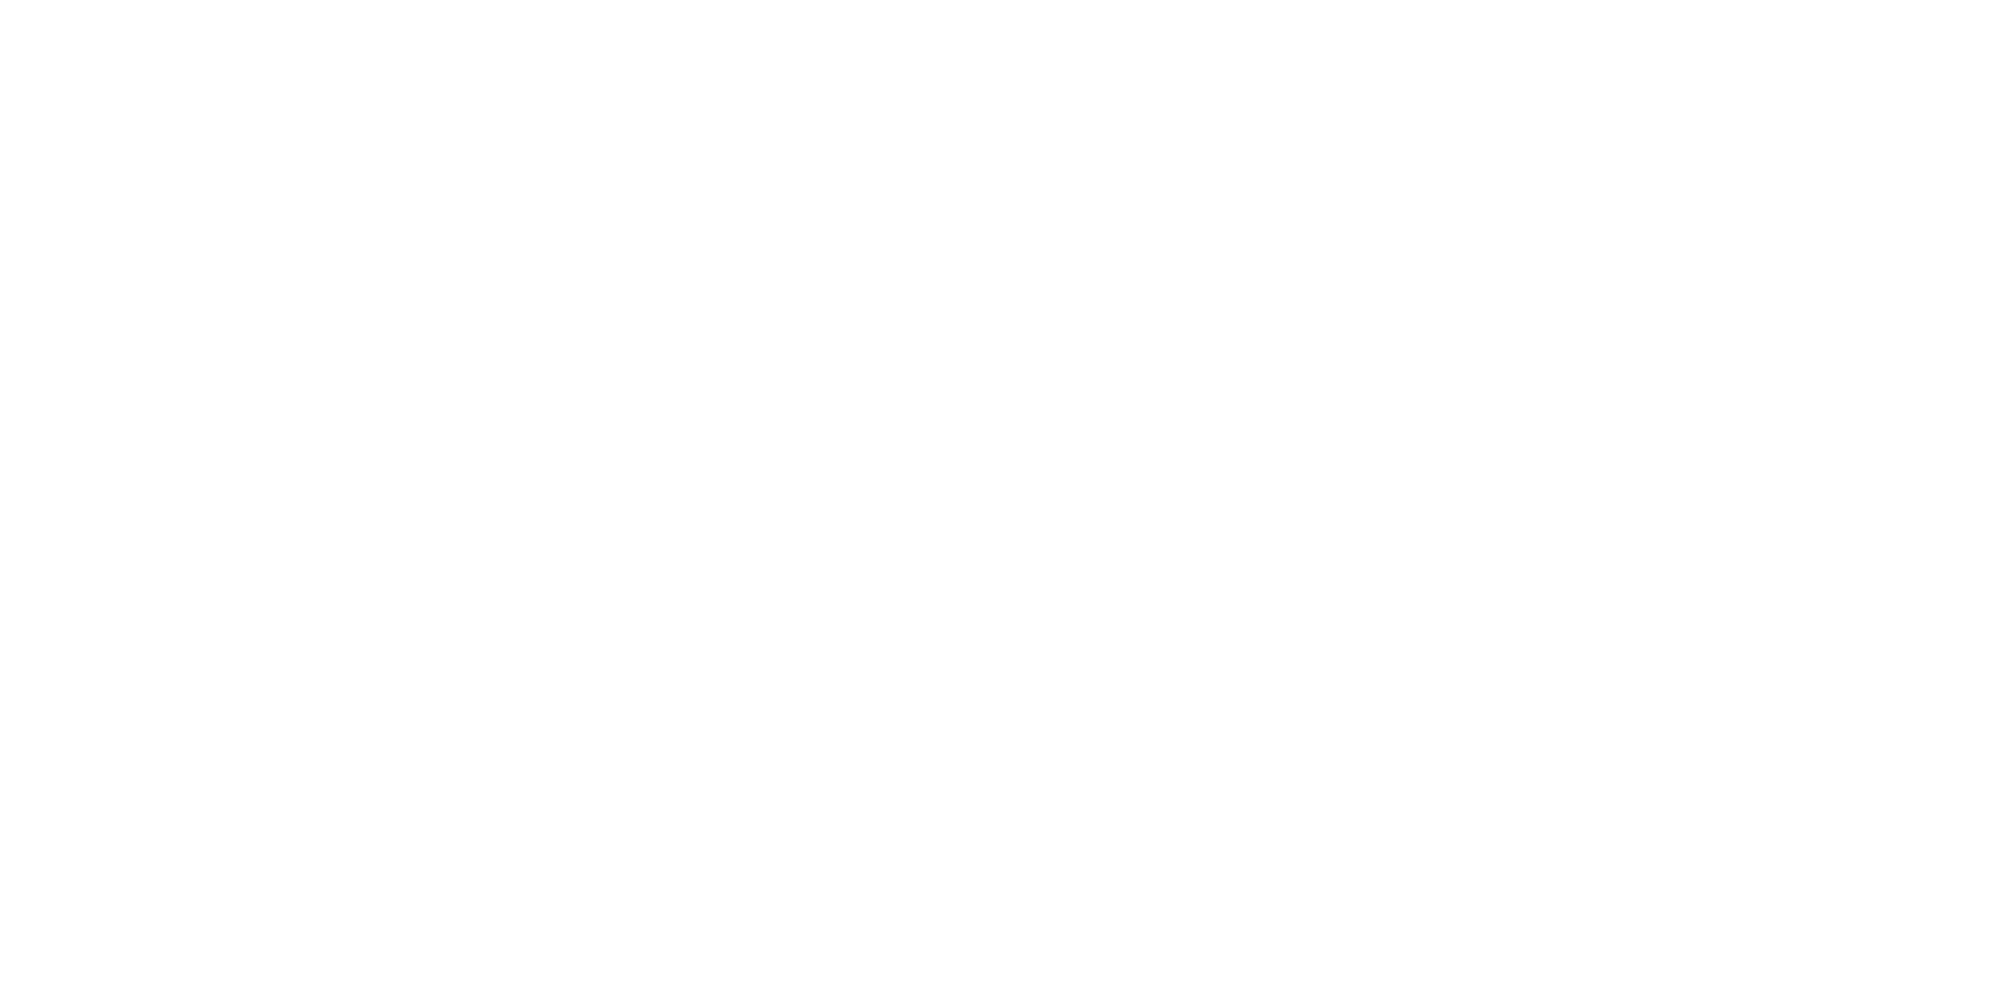

In [66]:
p = 0.1
num = 100
seed = 1234
graph = random_network(p, num, seed)


# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Person(i)

# create set of infecteds, initialize with 10 infecteds
init = np.random.choice(len(graph), 10, replace=False)

# time
t = 0
t_tot = 20
time_step = 365
dt = 1 / (time_step)

# constants of model
D = 0.19 * time_step
mu = 1e-3
PHI = [0.65, 0.50]
BETA = [0.59, 0.87]

# choose MSM or HMW to model
sextype = 0
phi = PHI[sextype]
beta = BETA[sextype]
beta = 1 - (1 - beta)**(1 / time_step)
nu = 2e-3 * (1 - phi)
tau = 8e-3 * phi

# initial state
_, _, graph = model(beta, tau, nu, init, 0, graph)

# get values of disease status
values = []
for j in range(len(graph.nodes())):
    if graph.node[j]["Data"].disease_status == 0:
        values.append("Black")
    elif graph.node[j]["Data"].disease_status == 1:
        values.append("Blue")
    elif graph.node[j]["Data"].disease_status == 2:
        values.append("Red")
        
# create figure and set axes
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1, = ax2.plot([], [], c = 'b', label='all infecteds MSM')
im2, = ax2.plot([], [], c = 'r', label='resistant infecteds MSM')
ax2.legend()
ax2.set_xlim(0,20)
ax2.set_ylim(0,1000)

# initialize
pos = nx.spring_layout(graph) 
plt.close()
ani_step = 183
frames = 40
num_infected = np.zeros(ani_step*frames)
num_res = np.zeros(ani_step*frames)

# update function for animation
def update(i):
    temp_res, temp_infected, _ = model(beta, tau, nu, init, ani_step, graph, doInit=False, disable_progress=True)
    num_infected[i*ani_step:(i+1)*ani_step] = temp_infected
    num_res[i*ani_step:(i+1)*ani_step] = temp_res
    t = np.linspace(0,i*ani_step/365, i*ani_step) 
    im1.set_data(t, num_infected[:i*ani_step])
    im2.set_data(t, num_res[:i*ani_step])
    ax1.clear()
    
    # solution at step i
    values = []
    for j in range(len(graph.nodes())):
        if graph.node[j]["Data"].disease_status == 0:
            values.append("Black")
        elif graph.node[j]["Data"].disease_status == 1:
            values.append("Blue")
        elif graph.node[j]["Data"].disease_status == 2:
            values.append("Red")
    nx.draw(graph, pos=pos, node_color=values, node_size=10, ax=ax1, clim = 2)
    
    # Scale plot ax
    ax1.set_title("Frame %d:    "%(i+1), fontweight="bold")
    ax1.set_xticks([])
    ax1.set_yticks([])
    
# animate!
animation.FuncAnimation(fig, update, frames=40, interval=100, repeat=True)